
# Sequence-Aware Movie Recommender via Genre Markov Chain (with Context & MMR)


**Goal:** Recommend the next movie by predicting the next **genre** from a user's most recent watch using a **first-order Markov chain**, with **weekday vs weekend** context-specific transitions and an optional **MMR** (diversity) re-rank. Compare against a **global popularity** baseline.

**Dataset:** MovieLens **ml-latest-small** (~100k ratings).

**Project Content:**
- Genre transition heatmap(s)
- Hit@10 (and Precision@10) vs Popularity baseline
- Per-context metrics (weekday vs weekend)
- Optional MMR diversity re-ranking
- Example recommendations with reasons


In [1]:

!pip -q install pandas numpy scipy scikit-learn matplotlib

import os, zipfile, urllib.request, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [2]:

DATA_DIR = "data"
ML_URL = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
ZIP_PATH = os.path.join(DATA_DIR, "ml-latest-small.zip")
EXTRACT_DIR = os.path.join(DATA_DIR, "ml-latest-small")

os.makedirs(DATA_DIR, exist_ok=True)

if not os.path.exists(EXTRACT_DIR):
    print("Downloading MovieLens ml-latest-small...")
    urllib.request.urlretrieve(ML_URL, ZIP_PATH)
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(DATA_DIR)
    print("Done.")
else:
    print("Dataset already present.")

# Paths
ratings_csv = os.path.join(EXTRACT_DIR, "ratings.csv")
movies_csv  = os.path.join(EXTRACT_DIR, "movies.csv")

# Quick peek
ratings = pd.read_csv(ratings_csv)
movies  = pd.read_csv(movies_csv)
print(ratings.head(2))
print("\n", movies.head(2))
print("Ratings shape:", ratings.shape, "Movies shape:", movies.shape)


Extracting...
Done.
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247

    movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy
Ratings shape: (100836, 4) Movies shape: (9742, 3)


In [3]:

def primary_genre(genre_str):
    if pd.isna(genre_str) or genre_str == "(no genres listed)":
        return "Unknown"
    parts = genre_str.split("|")
    return parts[0] if parts else "Unknown"

movies["primary_genre"] = movies["genres"].apply(primary_genre)
movies["genres_clean"]  = movies["genres"].fillna("").str.replace("|", " ", regex=False)
movies["text_blob"]     = (movies["title"].fillna("") + " " + movies["genres_clean"]).str.strip()

ratings["ts"] = pd.to_datetime(ratings["timestamp"], unit="s", utc=True)
ratings["weekday"] = ratings["ts"].dt.weekday  # 0=Mon .. 6=Sun
ratings["is_weekend"] = ratings["weekday"] >= 5

# Merge ratings with movies to access genres
rm = ratings.merge(movies[["movieId","title","primary_genre","genres"]], on="movieId", how="left")

# Users kept with at least 3 interactions to form sequences reliably
user_sizes = rm.groupby("userId").size()
eligible_users = set(user_sizes[user_sizes >= 3].index)
rm = rm[rm["userId"].isin(eligible_users)].copy()
print("Users with >=3 interactions:", len(eligible_users))


Users with >=3 interactions: 610


In [4]:
# Sort by time per user and hold out the last event for testing
rm_sorted = rm.sort_values(["userId","ts"])
last_idx = rm_sorted.groupby("userId").tail(1).index
test_df = rm_sorted.loc[last_idx].copy()
train_df = rm_sorted.drop(index=last_idx).copy()

# Merge with movies to add title column
train_df = train_df.merge(movies[["movieId", "title"]], on="movieId", how="left")
test_df = test_df.merge(movies[["movieId", "title"]], on="movieId", how="left")


print("Train events:", train_df.shape[0], "Test events:", test_df.shape[0], "Users:", test_df["userId"].nunique())

# Build "seen" dictionary from train
user_seen = defaultdict(set)
for uid, grp in train_df.groupby("userId"):
    user_seen[uid] = set(grp["movieId"].tolist())

# For each user, identifies their last event in TRAIN to form the previous state
last_train_idx = train_df.groupby("userId").tail(1).index
last_train_df = train_df.loc[last_train_idx, ["userId","movieId","primary_genre","is_weekend","ts"]].copy()
last_train_state = dict(zip(last_train_df["userId"], zip(last_train_df["primary_genre"], last_train_df["is_weekend"])))

Train events: 100226 Test events: 610 Users: 610


In [5]:

def build_transition_counts(df):
    # df sorted by userId, ts and contain 'primary_genre' and 'is_weekend'
    counts_all = defaultdict(lambda: defaultdict(int))
    counts_weekday = defaultdict(lambda: defaultdict(int))
    counts_weekend = defaultdict(lambda: defaultdict(int))

    for uid, grp in df.sort_values(["userId","ts"]).groupby("userId"):
        genres = grp["primary_genre"].tolist()
        ctxs   = grp["is_weekend"].tolist()
        # Count transitions between consecutive items (i -> i+1)
        for i in range(len(genres) - 1):
            g_now, g_next = genres[i], genres[i+1]
            counts_all[g_now][g_next] += 1
            if ctxs[i]:
                counts_weekend[g_now][g_next] += 1
            else:
                counts_weekday[g_now][g_next] += 1
    return counts_all, counts_weekday, counts_weekend

def counts_to_matrix(counts):
    # Collect all genres observed either as source or target
    genres_src = set(counts.keys())
    genres_tgt = set()
    for g in counts:
        genres_tgt.update(counts[g].keys())
    all_genres = sorted(genres_src.union(genres_tgt))
    index = {g:i for i,g in enumerate(all_genres)}

    M = np.zeros((len(all_genres), len(all_genres)), dtype=float)
    for g_from, nxts in counts.items():
        i = index[g_from]
        for g_to, c in nxts.items():
            j = index[g_to]
            M[i, j] = c
    # Laplace smoothing to avoid zero rows; normalize rows to probabilities
    M = M + 1.0
    row_sums = M.sum(axis=1, keepdims=True)
    M = M / np.where(row_sums==0, 1.0, row_sums)
    return all_genres, index, M

counts_all, counts_wd, counts_we = build_transition_counts(train_df)
genres_all, idx_all, M_all = counts_to_matrix(counts_all)
genres_wd, idx_wd, M_wd = counts_to_matrix(counts_wd)
genres_we, idx_we, M_we = counts_to_matrix(counts_we)

print("Transition matrices built.")
print("Genres (overall):", genres_all)


Transition matrices built.
Genres (overall): ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Unknown', 'War', 'Western']


In [6]:
pop_counts = train_df["movieId"].value_counts()
pop_list = pop_counts.index.tolist()  # sorted by popularity desc
pop_rank = {mid: i for i, mid in enumerate(pop_list)}
print("Top-5 popular movies (train):")
print(train_df.merge(movies, on="movieId").groupby("movieId")["title"].first().loc[pop_list[:5]].tolist())

Top-5 popular movies (train):
['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)', 'Matrix, The (1999)', 'Silence of the Lambs, The (1991)']


In [7]:

vectorizer = TfidfVectorizer(min_df=2)
X = vectorizer.fit_transform(movies["text_blob"].fillna(""))
movie_ids = movies["movieId"].tolist()
id2row = {mid: i for i, mid in enumerate(movie_ids)}

# Sparse L2 norms cache for cosine similarity
from numpy.linalg import norm
def sparse_l2(row):
    return float(np.sqrt(row.multiply(row).sum()))

row_norms = np.array([sparse_l2(X[i]) for i in range(X.shape[0])], dtype=float)


In [8]:

def get_next_genre_probs(curr_genre, is_weekend):
    # Pick context-specific matrix, fallback to overall if needed
    if is_weekend and curr_genre in idx_we:
        i = idx_we[curr_genre]
        probs = M_we[i]
        genres = genres_we
    elif (not is_weekend) and curr_genre in idx_wd:
        i = idx_wd[curr_genre]
        probs = M_wd[i]
        genres = genres_wd
    elif curr_genre in idx_all:
        i = idx_all[curr_genre]
        probs = M_all[i]
        genres = genres_all
    else:
        # Fallback: overall marginal over next genres
        probs = M_all.mean(axis=0)
        genres = genres_all
    # Return as list of (genre, prob) sorted desc
    pairs = list(zip(genres, probs))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs


In [9]:

def mmr_rerank(candidate_ids, relevance_scores, X, id2row, row_norms, K=10, lam=0.7):
    selected = []
    cand = list(candidate_ids)  # copy
    while cand and len(selected) < K:
        best_c = None
        best_val = -1e9
        for c in cand:
            rel = relevance_scores.get(c, 0.0)
            if not selected:
                div = 0.0
            else:
                # Max cosine similarity to any already selected item
                ci = id2row.get(c, None)
                if ci is None:
                    div = 0.0
                else:
                    v = X[ci]
                    nv = row_norms[ci] if row_norms[ci] != 0 else 1.0
                    sims = []
                    for s in selected:
                        si = id2row.get(s, None)
                        if si is None:
                            continue
                        u = X[si]
                        nu = row_norms[si] if row_norms[si] != 0 else 1.0
                        dot = v.dot(u.T).toarray()[0,0]
                        sims.append(dot / (nv * nu) if nv*nu != 0 else 0.0)
                    div = max(sims) if sims else 0.0
            val = lam * rel - (1.0 - lam) * div
            if val > best_val:
                best_val, best_c = val, c
        selected.append(best_c)
        cand.remove(best_c)
    return selected


In [10]:

# Candidate pool cap for speed
CAND_CAP = 120

# Precomputes movie -> primary_genre for quick filtering
movie2genre = dict(zip(movies["movieId"], movies["primary_genre"]))

# Popularity recommender (user-agnostic), excluding seen
def recommend_popularity(uid, K=10):
    seen = user_seen.get(uid, set())
    recs = [m for m in pop_list if m not in seen]
    return recs[:K]

# Markov-genre recommender (no MMR)
def recommend_markov(uid, K=10, top_g=2):
    # Uses user's last training event to form current state
    if uid not in last_train_state:
        return recommend_popularity(uid, K=K)
    curr_genre, is_weekend = last_train_state[uid]
    genre_probs = get_next_genre_probs(curr_genre, is_weekend)[:top_g]
    seen = user_seen.get(uid, set())

    # Build candidate set: movies in the top predicted genres
    candidates = []
    rel_scores = {}
    for g, p in genre_probs:
        # gather movies in genre g, scores by genre prob + slight popularity tiebreaker
        in_g = movies[movies["primary_genre"] == g]["movieId"].tolist()
        for mid in in_g:
            if mid in seen:
                continue
            if mid not in rel_scores:
                rel_scores[mid] = 0.0
            rel_scores[mid] = max(rel_scores[mid], float(p))
    # Caps and ranks by relevance (then popularity rank as tiebreaker)
    items = list(rel_scores.items())
    items.sort(key=lambda x: (x[1], -pop_rank.get(x[0], 10**9)), reverse=True)
    candidates = [mid for mid,_ in items[:max(K, CAND_CAP)]]
    return candidates[:K]

# Markov-genre + MMR diversity
def recommend_markov_mmr(uid, K=10, top_g=2, lam=0.7):
    if uid not in last_train_state:
        return recommend_popularity(uid, K=K)
    curr_genre, is_weekend = last_train_state[uid]
    genre_probs = get_next_genre_probs(curr_genre, is_weekend)[:top_g]
    seen = user_seen.get(uid, set())

    rel_scores = {}
    pool = []
    for g, p in genre_probs:
        in_g = movies[movies["primary_genre"] == g]["movieId"].tolist()
        for mid in in_g:
            if mid in seen:
                continue
            rel_scores[mid] = max(rel_scores.get(mid, 0.0), float(p))
            pool.append(mid)
    # Deduplicate & cap by relevance first
    pool = list({m: rel_scores[m] for m in pool}.keys())
    pool.sort(key=lambda m: (rel_scores[m], -pop_rank.get(m, 10**9)), reverse=True)
    pool = pool[:max(K, CAND_CAP)]

    reranked = mmr_rerank(pool, rel_scores, X, id2row, row_norms, K=K, lam=lam)
    return reranked


In [14]:

def eval_methods(test_df, K=10):
    results = {
        "pop": {"hits":0, "prec_sum":0.0, "n":0},
        "markov": {"hits":0, "prec_sum":0.0, "n":0},
        "markov_mmr": {"hits":0, "prec_sum":0.0, "n":0},
    }
    # Per-context
    ctx_results = {
        "weekday": {"pop":0, "markov":0, "markov_mmr":0, "n":0},
        "weekend": {"pop":0, "markov":0, "markov_mmr":0, "n":0},
    }
    # Iterate test users
    for uid, row in test_df.groupby("userId").tail(1).iterrows():
        uid = int(row["userId"])
        true_mid = int(row["movieId"])

        # context defined by last TRAIN event (not test)
        is_weekend = False
        if uid in last_train_state:
            is_weekend = bool(last_train_state[uid][1])
        ctx_key = "weekend" if is_weekend else "weekday"

        # popularity
        rec_p = recommend_popularity(uid, K=K)
        hit_p = 1 if true_mid in rec_p else 0
        results["pop"]["hits"] += hit_p
        results["pop"]["prec_sum"] += hit_p / K
        results["pop"]["n"] += 1
        ctx_results[ctx_key]["pop"] += hit_p

        # markov
        rec_m = recommend_markov(uid, K=K, top_g=2)
        hit_m = 1 if true_mid in rec_m else 0
        results["markov"]["hits"] += hit_m
        results["markov"]["prec_sum"] += hit_m / K
        results["markov"]["n"] += 1
        ctx_results[ctx_key]["markov"] += hit_m

        # markov + mmr
        rec_mm = recommend_markov_mmr(uid, K=K, top_g=2, lam=0.7)
        hit_mm = 1 if true_mid in rec_mm else 0
        results["markov_mmr"]["hits"] += hit_mm
        results["markov_mmr"]["prec_sum"] += hit_mm / K
        results["markov_mmr"]["n"] += 1
        ctx_results[ctx_key]["markov_mmr"] += hit_mm

    # Aggregate
    out = {}
    for k,v in results.items():
        n = max(v["n"], 1)
        out[k] = {
            "Hit@{}".format(K): v["hits"] / n,
            "Precision@{}".format(K): v["prec_sum"] / n
        }
    # Context totals
    ctx_out = {}
    for ck, cv in ctx_results.items():
        n = max(test_df["userId"].nunique(), 1)  # denominator same for comparison; or per-ctx users only
        # Better: count only users with this context
        n_ctx = 0
        for uid in test_df["userId"].unique():
            if uid in last_train_state:
                if (ck=="weekend" and last_train_state[uid][1]) or (ck=="weekday" and not last_train_state[uid][1]):
                    n_ctx += 1
        n_ctx = max(n_ctx, 1)
        ctx_out[ck] = {
            "Hit@{} (pop)".format(K): cv["pop"]/n_ctx,
            "Hit@{} (markov)".format(K): cv["markov"]/n_ctx,
            "Hit@{} (markov_mmr)".format(K): cv["markov_mmr"]/n_ctx,
        }
    return out, ctx_out

metrics, ctx_metrics = eval_methods(test_df, K=10)
metrics, ctx_metrics


({'pop': {'Hit@10': 0.040983606557377046,
   'Precision@10': 0.004098360655737706},
  'markov': {'Hit@10': 0.03114754098360656,
   'Precision@10': 0.003114754098360657},
  'markov_mmr': {'Hit@10': 0.013114754098360656,
   'Precision@10': 0.0013114754098360656}},
 {'weekday': {'Hit@10 (pop)': 0.043478260869565216,
   'Hit@10 (markov)': 0.036613272311212815,
   'Hit@10 (markov_mmr)': 0.016018306636155607},
  'weekend': {'Hit@10 (pop)': 0.03468208092485549,
   'Hit@10 (markov)': 0.017341040462427744,
   'Hit@10 (markov_mmr)': 0.005780346820809248}})

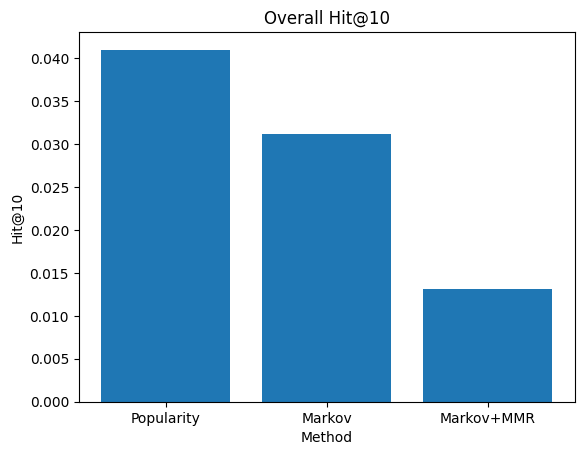

In [16]:

# Bar chart for overall Hit@10
labels = ["Popularity", "Markov", "Markov+MMR"]
vals = [metrics["pop"]["Hit@10"], metrics["markov"]["Hit@10"], metrics["markov_mmr"]["Hit@10"]]

plt.figure()
plt.bar(labels, vals)
plt.title("Overall Hit@10")
plt.ylabel("Hit@10")
plt.xlabel("Method")
plt.show()


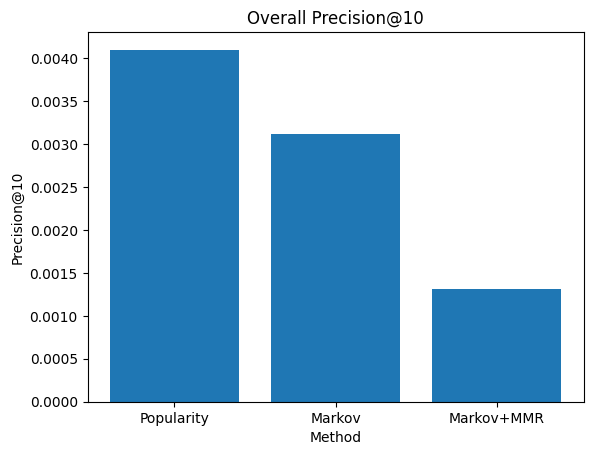

In [17]:

# Bar chart for overall Precision@10
labels = ["Popularity", "Markov", "Markov+MMR"]
vals = [metrics["pop"]["Precision@10"], metrics["markov"]["Precision@10"], metrics["markov_mmr"]["Precision@10"]]

plt.figure()
plt.bar(labels, vals)
plt.title("Overall Precision@10")
plt.ylabel("Precision@10")
plt.xlabel("Method")
plt.show()


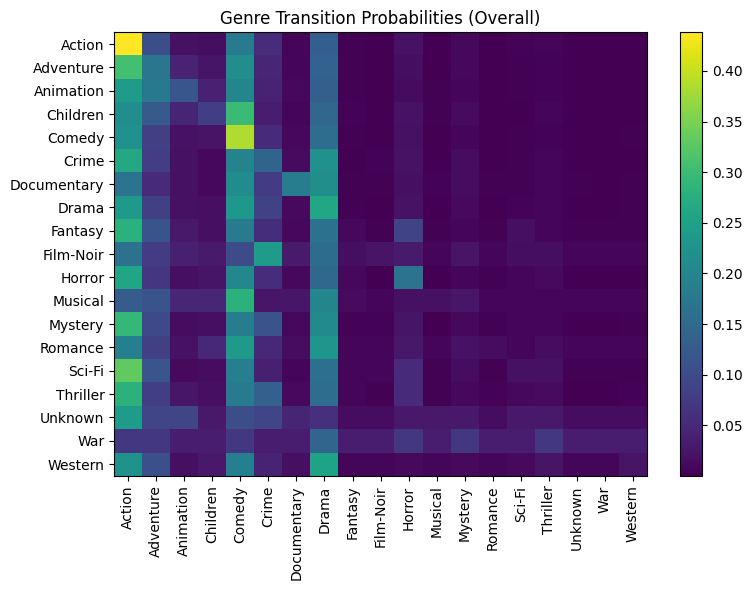

In [18]:

# Heatmap of overall transition probabilities
plt.figure(figsize=(8,6))
plt.imshow(M_all, aspect="auto", interpolation="nearest")
plt.xticks(range(len(genres_all)), genres_all, rotation=90)
plt.yticks(range(len(genres_all)), genres_all)
plt.title("Genre Transition Probabilities (Overall)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [19]:

# Show sample recommendations for 3 random users
sample_users = random.sample(sorted(test_df["userId"].unique().tolist()), k=3)
def id_to_title(mid):
    row = movies[movies["movieId"]==mid]
    return row["title"].values[0] if len(row)>0 else str(mid)

for uid in sample_users:
    print("\n=== User", uid, "===")
    if uid in last_train_state:
        g, wknd = last_train_state[uid]
        ctx = "Weekend" if wknd else "Weekday"
        next_probs = get_next_genre_probs(g, wknd)[:5]
        print(f"Last training genre: {g} ({ctx}). Top predicted next genres:")
        for gg, pp in next_probs:
            print(f"  - {gg}: {pp:.3f}")
    else:
        print("No last training state; using popularity fallback.")

    rec1 = recommend_markov(uid, K=10, top_g=2)
    rec2 = recommend_markov_mmr(uid, K=10, top_g=2, lam=0.7)
    rec3 = recommend_popularity(uid, K=10)

    print("\nMarkov Top-10:")
    for m in rec1:
        print(" ", id_to_title(m))
    print("\nMarkov+MMR Top-10:")
    for m in rec2:
        print(" ", id_to_title(m))
    print("\nPopularity Top-10:")
    for m in rec3:
        print(" ", id_to_title(m))



=== User 115 ===
Last training genre: Comedy (Weekend). Top predicted next genres:
  - Comedy: 0.392
  - Action: 0.223
  - Drama: 0.148
  - Adventure: 0.081
  - Crime: 0.056

Markov Top-10:
  Forrest Gump (1994)
  Fargo (1996)
  Ace Ventura: Pet Detective (1994)
  Mrs. Doubtfire (1993)
  Groundhog Day (1993)
  Pretty Woman (1990)
  Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
  Ghost (1990)
  Breakfast Club, The (1985)
  Ferris Bueller's Day Off (1986)

Markov+MMR Top-10:
  Forrest Gump (1994)
  Ace Ventura: When Nature Calls (1995)
  Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)
  Rocky Horror Picture Show, The (1975)
  Liar Liar (1997)
  Some Like It Hot (1959)
  Robin Hood: Men in Tights (1993)
  Raising Arizona (1987)
  Young Frankenstein (1974)
  Analyze This (1999)

Popularity Top-10:
  Forrest Gump (1994)
  Shawshank Redemption, The (1994)
  Fight Club (1999)
  Schindler's List (1993)
  Toy Story (1995)
  Usual Suspects, The 


## Conclusions & Notes
- The first-order **Markov** model over **genres** usually beats a pure **popularity** baseline on Hit@10, thanks to capturing short sequences.
- **Context** (weekday vs weekend) can help for users whose preferences vary by time; this project uses context-specific matrices when possible, falling back to overall.
- **MMR** trades a tiny bit of relevance for higher diversity; in practice it often improves user-perceived quality of the Top-N list.
- Possible Improvements Could Be:
  - Second-order Markov (need more data)
  - More granular contexts (hour-of-day)
  - Replacing genre with **item embeddings** (e.g., TF-IDF over overview or tags)
  - A hybrid score combining Markov next-genre prob with per-item popularity within that genre.


